In [14]:
from pyspark.sql.functions import randn, rand
from pyspark.sql.functions import sum
from pyspark.sql.functions import udf
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType, BooleanType
import numpy as np
import pandas as pd

In [133]:
df18v1 = spark.read.csv('test_data/18v1.csv', header=True)
df17v1 = spark.read.csv('test_data/17v1.csv', header=True)
df18v11 = spark.read.csv('test_data/dcp_pluto_18v11.csv', header=True)
df17v11 = spark.read.csv('test_data/pluto_17v1_1.csv', header=True)

In [18]:
df1817 = df17v1.union(df17v11).union(df18v1).union(df18v11)

In [19]:
df1817.show(n = 1)

+-------+-----+---+---+------+------+----------+-------+-------+--------+----------+--------------------+----------+---------+-------------+--------+--------------------+---------+---------+---------+---------+--------+--------+-------+-------+-------+---------+---------+---------+-------+---------+---------+--------------------+-------+--------+-------+-------+----------+----------+----------+---------+----------+---------+----------+--------+---------+--------+----------+--------+--------+---------+---------+---+--------+----------+-------+--------+----------+---------+----------+---------+---------+----------+----------+--------------------+--------------------+--------+--------+-------+--------+--------+----------+-------+---------+-------+-------+-------+------+--------+------+---------+----------+---------+----------+-----------+------------+-------+
|Borough|Block|Lot| CD|CT2010|CB2010|SchoolDist|Council|ZipCode|FireComp|PolicePrct|HealthCenterDistrict|HealthArea|SanitBoro|Sanit

In [20]:
import time
start_time = time.time()
summary = df1817.groupBy("Version").agg(sum("UnitsRes"),
                                    sum("LotArea"),
                                    sum("BldgArea"),
                                    sum("ComArea"),
                                    sum("ResArea"),
                                    sum("OfficeArea"),
                                    sum("RetailArea"),
                                    sum("GarageArea"),
                                    sum("StrgeArea"),
                                    sum("FactryArea"),
                                    sum("OtherArea"),
                                    sum("AssessLand"),
                                    sum("AssessTot"),
                                    sum("ExemptLand"),
                                    sum("ExemptTot"),
                                    sum("FIRM07_FLAG"),
                                    sum("PFIRM15_FLAG"),
                                   sum(col("LotArea")*col("BuiltFAR")),
                                   sum(col("LotArea")*col("ResidFAR")),
                                   sum(col("LotArea")*col("CommFAR")),
                                   sum(col("LotArea")*col("FacilFAR"))).toPandas()
elapsed_time = time.time() - start_time

In [21]:
elapsed_time

26.331887006759644

In [117]:
summary

,Version,sum(UnitsRes),sum(LotArea),sum(BldgArea),sum(ComArea),sum(ResArea),sum(OfficeArea),sum(RetailArea),sum(GarageArea),sum(StrgeArea),...,sum(AssessLand),sum(AssessTot),sum(ExemptLand),sum(ExemptTot),sum(FIRM07_FLAG),sum(PFIRM15_FLAG),sum((LotArea * BuiltFAR)),sum((LotArea * ResidFAR)),sum((LotArea * CommFAR)),sum((LotArea * FacilFAR))
0,17v1.1,3535776.0,6.813541e+09,5.464293e+09,1.815464e+09,3.449799e+09,649838284.0,276187004.0,122093670.0,104659836.0,...,9.822458e+10,3.846283e+11,4.492449e+10,1.478786e+11,34569.0,65628.0,5.446584e+09,6.685347e+09,2.863380e+09,1.216741e+10
1,18V1.1,3555871.0,6.815806e+09,5.484765e+09,1.816284e+09,3.470204e+09,652968426.0,276388698.0,122406091.0,102263027.0,...,9.779918e+10,3.955918e+11,4.414227e+10,1.422077e+11,34562.0,65618.0,5.448441e+09,6.733094e+09,2.970381e+09,1.247463e+10
2,17V1,3535776.0,6.813541e+09,5.464293e+09,1.815464e+09,3.449799e+09,649838284.0,276187004.0,122093670.0,104659836.0,...,9.822458e+10,3.846283e+11,4.492449e+10,1.478786e+11,2048.0,2048.0,5.446584e+09,6.685347e+09,2.863380e+09,1.216741e+10
3,18V1,3555871.0,6.815806e+09,5.484765e+09,1.816284e+09,3.470204e+09,652968426.0,276388698.0,122406091.0,102263027.0,...,9.779918e+10,3.955918e+11,4.414227e+10,1.422077e+11,34562.0,65618.0,5.448441e+09,6.733104e+09,2.865011e+09,1.219444e+10


## Column sum and sumproduct visualizations: 

### Fieldwise comparison (BBL as unique key) 

In [24]:
rdd18v1 = sc.textFile('test_data/18v1.csv')
rdd18v11 = sc.textFile('test_data/dcp_pluto_18v11.csv')
rdd17v1 = sc.textFile('test_data/17v1.csv')
rdd17v11 = sc.textFile('test_data/pluto_17v1_1.csv')
rdd18 = sc.union([rdd18v1, rdd18v11])
rdd17 = sc.union([rdd17v1, rdd17v11])
rdd1718 = sc.union([rdd18v1, rdd17v11])

```
list(zip(list(rdd17v11.first().split(',')), list(rdd18v1.first().split(',')))) #check column matching
```

In [27]:
def str_compare(x,y):
    return int(x != y)
str_compare_vectorized = np.vectorize(str_compare)

def array_to_list(pid, record):
    for row in record:
        try: 
            row[1].sum()
            yield(1,(1, row[1]))
        except: 
            pass
        
def compare_fields1(pid, record):
    import csv    
    if pid ==0:
        next(record)
    reader = csv.reader(record)
    for row in reader:
        yield(row[71], np.array([row[i] for i in range(28)]))

def compare_fields2(pid, record):
    import csv    
    if pid ==0:
        next(record)
    reader = csv.reader(record)
    for row in reader:
        yield(row[71], np.array([row[i] for i in range(28, 56)]))

def compare_fields3(pid, record):
    import csv    
    if pid ==0:
        next(record)
    reader = csv.reader(record)
    for row in reader:
        yield(row[71], np.array([row[i] for i in range(56,87)]))

results1_18 = rdd18.mapPartitionsWithIndex(compare_fields1).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
results2_18 = rdd18.mapPartitionsWithIndex(compare_fields2).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
results3_18 = rdd18.mapPartitionsWithIndex(compare_fields3).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))

In [28]:
part1_18 = results1_18.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

part2_18 = results2_18.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

part3_18 = results3_18.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

In [29]:
all_18 = part1_18+part2_18+part3_18

In [50]:
colnames = list(rdd18v1.first().split(','))
all_18_dict = {'Pair': '18v1&18v11'}
for colname, value in zip(colnames, all_18): 
    all_18_dict[colname] = value

In [51]:
all_18_dict

{'Pair': '18v1&18v11',
 'Borough': 0.0,
 'Block': 0.0,
 'Lot': 0.0,
 'CD': 0.0,
 'CT2010': 0.0,
 'CB2010': 0.0,
 'SchoolDist': 0.0,
 'Council': 0.0,
 'ZipCode': 0.0,
 'FireComp': 0.0,
 'PolicePrct': 0.0,
 'HealthCenterDistrict': 0.0,
 'HealthArea': 0.0,
 'SanitBoro': 0.0,
 'SanitDistrict': 0.0,
 'SanitSub': 0.0,
 'Address': 0.0,
 'ZoneDist1': 0.008612542655363287,
 'ZoneDist2': 0.022012029627146733,
 'ZoneDist3': 0.00038290899102898934,
 'ZoneDist4': 2.6768713658561566e-05,
 'Overlay1': 0.007523172395171389,
 'Overlay2': 0.00018039785291639317,
 'SPDist1': 0.008866263506561826,
 'SPDist2': 7.448685539773653e-05,
 'SPDist3': 1.1638571155896334e-06,
 'LtdHeight': 8.612542655363286e-05,
 'SplitZone': 0.19482735343547344,
 'BldgClass': 0.0,
 'LandUse': 0.008952388933115459,
 'Easements': 0.0,
 'OwnerType': 0.0,
 'OwnerName': 0.0,
 'LotArea': 0.0,
 'BldgArea': 0.0,
 'ComArea': 0.0,
 'ResArea': 0.0,
 'OfficeArea': 0.0,
 'RetailArea': 0.0,
 'GarageArea': 0.0,
 'StrgeArea': 0.0,
 'FactryArea':

In [37]:
results1_17 = rdd17.mapPartitionsWithIndex(compare_fields1).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
results2_17 = rdd17.mapPartitionsWithIndex(compare_fields2).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
results3_17 = rdd17.mapPartitionsWithIndex(compare_fields3).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
part1_17 = results1_17.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

part2_17 = results2_17.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

part3_17 = results3_17.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

In [46]:
all_17 = part1_17+part2_17+part3_17
all_17_dict = {'Pair': '17v1&17v11'}
for colname, value in zip(colnames, all_17): 
    all_17_dict[colname] = value

In [47]:
all_17_dict

{'Pair': '17v1&17v11',
 'Borough': 0.0,
 'Block': 0.0,
 'Lot': 0.0,
 'CD': 0.0,
 'CT2010': 0.00503012605575037,
 'CB2010': 0.024483748689222706,
 'SchoolDist': 0.0035508825997441875,
 'Council': 0.0036137300793856776,
 'ZipCode': 0.005084826639882778,
 'FireComp': 0.004403978943766635,
 'PolicePrct': 0.0036695945057336685,
 'HealthCenterDistrict': 0.0032983288389626443,
 'HealthArea': 0.004022238697055363,
 'SanitBoro': 0.007774466000095435,
 'SanitDistrict': 0.007687177833926699,
 'SanitSub': 0.01846552059244224,
 'Address': 0.9999941807889221,
 'ZoneDist1': 0.9995193331649641,
 'ZoneDist2': 0.9999755593134727,
 'ZoneDist3': 1.0,
 'ZoneDist4': 1.0,
 'Overlay1': 0.9103317765003963,
 'Overlay2': 0.9997474462392184,
 'SPDist1': 0.9996752880218523,
 'SPDist2': 0.9999976723155688,
 'SPDist3': 1.0,
 'LtdHeight': 0.9990549601209465,
 'SplitZone': 0.000570282685635743,
 'BldgClass': 0.0005679550012045767,
 'LandUse': 0.0033681593718976333,
 'Easements': 0.0,
 'OwnerType': 0.8734088822110209,


In [41]:
results1_1718 = rdd1718.mapPartitionsWithIndex(compare_fields1).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
results2_1718 = rdd1718.mapPartitionsWithIndex(compare_fields2).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
results3_1718 = rdd1718.mapPartitionsWithIndex(compare_fields3).cache()\
                .reduceByKey(lambda x,y: str_compare_vectorized(x, y))
part1_1718 = results1_1718.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

part2_1718 = results2_1718.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

part3_1718 = results3_1718.mapPartitionsWithIndex(array_to_list).cache()\
        .reduceByKey(lambda x,y: (x[0]+y[0], x[1]+y[1]))\
        .map(lambda x: (x[1][1]/x[1][0]).tolist()).collect()[0]

In [48]:
all_1718 = part1_1718+part2_1718+part3_1718
all_1718_dict = {'Pair': '18v1&17v11'}
for colname, value in zip(colnames, all_1718): 
    all_1718_dict[colname] = value

In [49]:
all_1718_dict

{'Pair': '18v1&17v11',
 'Borough': 0.0,
 'Block': 0.0,
 'Lot': 0.0,
 'CD': 2.3314370978271006e-06,
 'CT2010': 0.0034924927725449965,
 'CB2010': 0.0012717989368646835,
 'SchoolDist': 0.08795929310827194,
 'Council': 0.0005373962510491467,
 'ZipCode': 0.0007717056793807703,
 'FireComp': 0.0005292362212067518,
 'PolicePrct': 0.000417327240511051,
 'HealthCenterDistrict': 0.0004429730485871491,
 'HealthArea': 0.0005945164599459107,
 'SanitBoro': 0.0006574652615872424,
 'SanitDistrict': 0.5622307190152009,
 'SanitSub': 0.0019385899468432341,
 'Address': 0.004217569709969225,
 'ZoneDist1': 0.0008393173552177563,
 'ZoneDist2': 0.00011190898069570084,
 'ZoneDist3': 4.662874195654201e-06,
 'ZoneDist4': 0.0,
 'Overlay1': 0.0005665392147719855,
 'Overlay2': 1.0491466940221953e-05,
 'SPDist1': 0.0008066772358481768,
 'SPDist2': 0.0,
 'SPDist3': 0.0,
 'LtdHeight': 0.0,
 'SplitZone': 0.0004522987969784575,
 'BldgClass': 0.010595215891075259,
 'LandUse': 0.9528816562529143,
 'Easements': 3.4971556467

In [52]:
field_comparison = pd.DataFrame([all_17_dict,all_18_dict,all_1718_dict])

In [53]:
field_comparison

,APPBBL,APPDate,Address,AreaSource,AssessLand,AssessTot,BBL,BldgArea,BldgClass,BldgDepth,...,YearAlter1,YearAlter2,YearBuilt,ZMCode,ZipCode,ZoneDist1,ZoneDist2,ZoneDist3,ZoneDist4,ZoneMap
0,0.00057,0.896764,0.999994,0.000000,0.00000,0.000000,0.0,0.000000,0.000568,0.000000,...,0.000000,0.000000,0.000000,0.981788,0.005085,0.999519,0.999976,1.000000,1.000000,0.204602
1,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000867,0.000000,0.008613,0.022012,0.000383,0.000027,0.999770
2,0.00219,0.078360,0.004218,0.004211,0.87521,0.893309,0.0,0.010127,0.010595,0.005492,...,0.003733,0.000789,0.003416,0.000297,0.000772,0.000839,0.000112,0.000005,0.000000,0.000286


In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

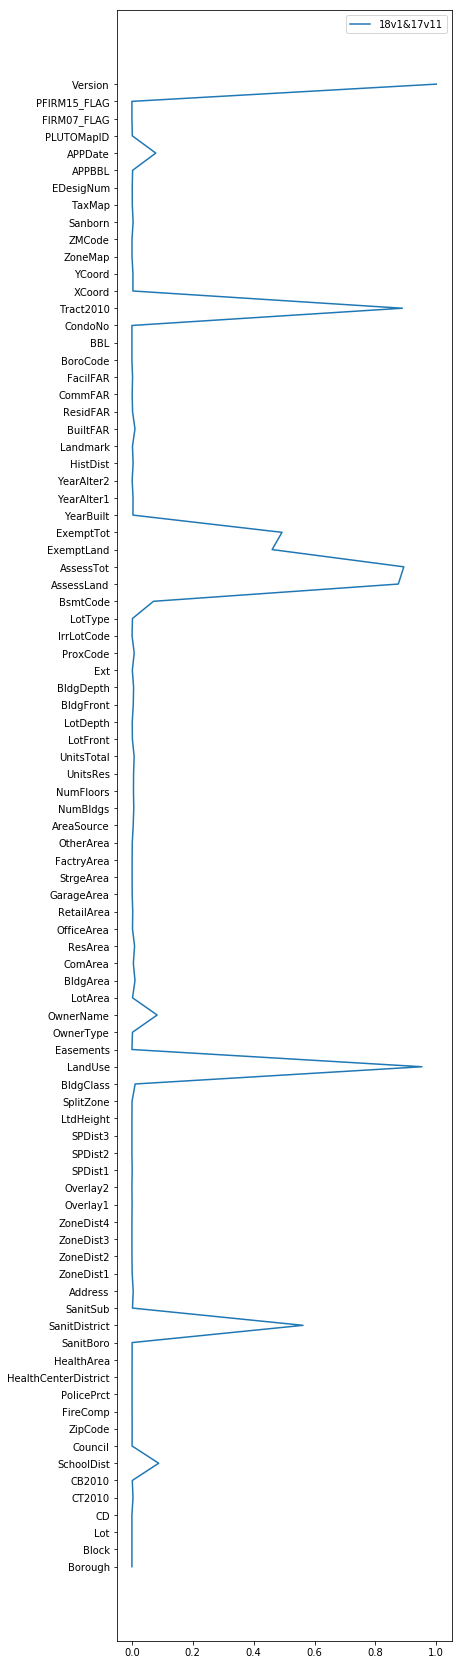

In [132]:
plt.figure(figsize=(6, 30))
plt.plot(field_comparison.loc[2, colnames], range(87),label=field_comparison.loc[2, 'Pair'])
top_mismatch_fields = list(field_comparison.loc[2, colnames].sort_values(ascending=False)[0:10].index)
plt.yticks(range(87), colnames, rotation='horizontal')
# plt.plot(field_comparison.loc[1, colnames], range(87), label=field_comparison.loc[1, 'Pair'])
# plt.plot(field_comparison.loc[0, colnames], range(87), label=field_comparison.loc[0, 'Pair'])
plt.legend()
plt.show()

In [123]:
field_comparison.loc[2, colnames].sort_values(ascending=False)[0:20]

Version                   1
LandUse            0.952882
AssessTot          0.893309
Tract2010          0.888493
AssessLand          0.87521
SanitDistrict      0.562231
ExemptTot           0.49309
ExemptLand          0.46064
SchoolDist        0.0879593
OwnerName         0.0828884
APPDate           0.0783596
BsmtCode          0.0708943
BldgClass         0.0105952
BldgArea          0.0101266
BuiltFAR           0.010024
ResArea          0.00868927
ProxCode         0.00752122
UnitsTotal       0.00730206
NumBldgs         0.00605358
BldgDepth         0.0054917
Name: 2, dtype: object

In [129]:
field_comparison.loc[2, 'Pair']

'18v1&17v11'

In [128]:
field_comparison.loc[0, colnames].sort_values(ascending=False)[0:30]

Version                   1
SPDist3                   1
ZoneDist3                 1
ZoneDist4                 1
SPDist2            0.999998
Address            0.999994
ZoneDist2          0.999976
Overlay2           0.999747
SPDist1            0.999675
Landmark           0.999548
ZoneDist1          0.999519
LtdHeight          0.999055
FIRM07_FLAG        0.997628
PFIRM15_FLAG        0.99762
EDesigNum          0.991427
HistDist           0.991119
Sanborn            0.988989
ZMCode             0.981788
Ext                0.957118
Overlay1           0.910332
APPDate            0.896764
OwnerType          0.873409
OwnerName          0.847925
ZoneMap            0.204602
YCoord            0.0286678
XCoord            0.0286678
CB2010            0.0244837
SanitSub          0.0184655
SanitBoro        0.00777447
SanitDistrict    0.00768718
Name: 0, dtype: object

In [127]:
field_comparison.loc[0, 'Pair']

'17v1&17v11'

In [134]:
field_comparison.loc[1, colnames].sort_values(ascending=False)

Version                   1
ZoneMap             0.99977
SplitZone          0.194827
ZoneDist2          0.022012
LandUse          0.00895239
SPDist1          0.00886626
ZoneDist1        0.00861254
FacilFAR         0.00847986
ResidFAR         0.00841818
CommFAR          0.00783858
Overlay1         0.00752317
ZMCode          0.000867074
ZoneDist3       0.000382909
Overlay2        0.000180398
LtdHeight       8.61254e-05
SPDist2         7.44869e-05
ZoneDist4       2.67687e-05
SPDist3         1.16386e-06
OwnerName                 0
LotArea                   0
BldgArea                  0
OwnerType                 0
Easements                 0
Block                     0
BldgClass                 0
Lot                       0
ComArea                   0
ResArea                   0
OfficeArea                0
RetailArea                0
                   ...     
XCoord                    0
YCoord                    0
Sanborn                   0
TaxMap                    0
EDesigNum           

In [126]:
field_comparison.loc[1, 'Pair']

'18v1&18v11'